Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Part 1: The seven scientists

This example is due to [MacKay 2003, exercise 22.15] and [Lee & Wagenmaker 2013, section 4.2].

Suppose seven scientists all go and perform the same experiment, each collecting a measurement $x_i$ for $i = 1,\dots,7$, of an underlying physical value $\mu$. 
 
These scientists are varyingly good at their job, and while we can assume each scientist would estimate $\mu$ correctly _on average_, some of them may have much more error in their measurements than others.

They come back with the following seven observations:


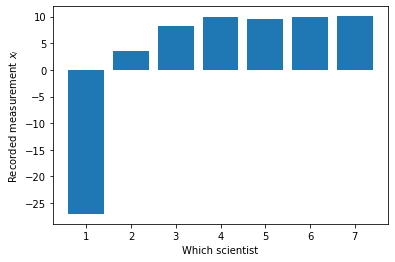

In [2]:
measurements = torch.FloatTensor([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])

plt.bar(np.arange(1,8), measurements) # , "o")
plt.xlabel("Which scientist")
plt.ylabel("Recorded measurement $x_i$");

From looking at the plot, clearly one scientist does not know what they are doing (and some of the others are probably a little suspect too)!


### A model for the data

In this exercise we will suppose that there is "scientist-specific" standard deviation $\sigma_i$, which describes how accurately each of them might perform the experiment:

$$\begin{align}
x_i &\sim \mathrm{Normal}(\mu, \sigma_i^2).
\end{align}$$

Scientists with low $\sigma_i$ produce good estimates of $x$, whereas scientists with high $\sigma_i$ might have wildly inaccurate estimates. However, we don't know _which_ scientists are good -- and we only have one observation from each!

We can ask two questions:

* What is the "real" value of $\mu$?
* What are the values of $\sigma_i$ for each scientists?



### Bayesian inference approach

You will have to choose priors for the mean $\mu$ of the measurements, and for the error standard deviation $\sigma\_i$ for each of the $i$ scientists. A good starting point is

$$\begin{align}
\mu &\sim \mathrm{Normal}(0, \alpha^2) \\
\sigma_i &\sim \mathrm{Exponential}(\beta)
\end{align}$$

where $\alpha=50$ and $\beta=0.5$. This is a prior distribution with mean 2 that places diminishing probability density on larger values of $\sigma_i$:


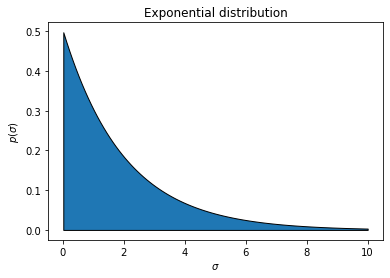

In [3]:
plt.fill_between(np.linspace(0.01,10,100), 0.0, 
                 dist.Exponential(rate=0.5).log_prob(torch.linspace(0.01,10,100)).exp(), 
                 edgecolor='k');
plt.xlabel("$\sigma$")
plt.ylabel("$p(\sigma)$")
plt.title("Exponential distribution");

# TASK #1 (3 points): Define the model

Given $\alpha=50, \beta=0.5$, and the measurements $x$ above, write a function to compute the unnormalized log density

$$\log p(\mu, x_1,\dots,x_7, \sigma_1,\dots, \sigma_7 | \alpha, \beta)$$

In [4]:
def log_joint(mu, sigma, alpha=50, beta=0.5):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    log_joint: the log probability log p(mu, sigma, x | alpha, beta), scalar
    
    NOTE: For inputs where sigma <= 0, please return negative infinity!

    """
    assert mu.ndim == 0
    assert sigma.shape == (7,)
    
    # YOUR CODE HERE
    
    # we need to find log(p(mu join data join sigma given a and b))
    # we assume mu and sigma are independent
    for elements in sigma:
        if elements <= 0:
            return torch.tensor(-float("inf"))
        
    # we check for negative alphas and betas for task 4
    if alpha <= 0 or beta <= 0:
        return torch.tensor(-float("inf"))
        
    p_sigma = dist.Exponential(rate=beta).log_prob(sigma)
    p_mu = dist.Normal(0, alpha).log_prob(mu)
    p_data = dist.Normal(mu, sigma).log_prob(measurements)
    
    return torch.sum(p_sigma) + p_mu + torch.sum(p_data)

#### Ignore the following cells. 

They consist of "hidden" test cases, and are used by the grading system.

In [5]:
# (GRADING)

In [6]:
# (GRADING)

# TASK #2 (5 points): Implement an MCMC sampler

Your second task is to implement an MCMC algorithm to sample from the posterior distribution

$$p(\mu, \sigma | x, \alpha, \beta).$$

To do this, you need to implement two functions:

* `get_mcmc_proposal`: this takes in current values of $\mu$ and $\sigma$, and returns pytorch `Distribution` objects (i.e., `torch.distributions.Distribution`, here in-scope as `dist.Distribution`) that will propose a next value given the current value, $q(\mu' | \mu, \dots)$ and $q(\sigma' | \sigma, \dots)$. It is **your choice** what sort of distribution to use here! Just make sure that whatever you propose works well in your MCMC algorithm.

* `mcmc_step`: this takes in current values of $\mu$ and $\sigma$, and runs a single Metropolis-Hastings step:
  1. sample candidate values from the proposal distribution you defined
  2. compute an acceptance probability, and either accept or reject
  3. return $\mu, \sigma$

In [7]:
def get_mcmc_proposal(mu, sigma):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0

    OUTPUT:
    q_mu    : instance of Distribution class, that defines a proposal for mu
    q_sigma : instance of Distribution class, that defines a proposal for sigma
    """
    
    # YOUR CODE HERE
    
    q_mu = dist.Normal(mu, 0.1)
    
    q_sigma = dist.Normal(sigma, 0.1)
    
    return q_mu, q_sigma


### Quick self-check!

If your `get_mcmc_proposal` has the correct function signature, all the following assertions should be true:

In [8]:
q_mu, q_sigma = get_mcmc_proposal(torch.tensor(9.0), torch.ones(7))
assert isinstance(q_mu, dist.Distribution)
assert isinstance(q_sigma, dist.Distribution)
assert q_mu.sample().shape == ()
assert q_sigma.sample().shape == (7,)
del q_mu, q_sigma

In [9]:
def mcmc_step(mu, sigma, alpha=50, beta=0.5):
    """
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    mu       : the next value of mu in the MCMC chain
    sigma    : the next value of sigma in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted

    """
    
    accepted = False
    q_mu, q_sigma = get_mcmc_proposal(mu, sigma)
    
    # YOUR CODE HERE
    # We sample from both distributions

    mu_prop = q_mu.sample()
    sigma_prop = q_sigma.sample()
    
    q_mu_prop, q_sigma_prop = get_mcmc_proposal(mu_prop, sigma_prop)
    logjoint_prop = log_joint(mu_prop, sigma_prop)
    logjoint = log_joint(mu, sigma)
    
    logsum = (logjoint_prop
              +q_mu_prop.log_prob(mu)
              +torch.sum(q_sigma_prop.log_prob(sigma)) 
              -logjoint
              -torch.sum(q_sigma.log_prob(sigma_prop))
              -q_mu.log_prob(mu_prop)
    )
   
    
    A = min(1,torch.exp_(logsum))
    if A > np.random.rand():
        accepted = True
        mu = mu_prop
        sigma = sigma_prop
        
    return mu, sigma, accepted

## Running MCMC

We've supplied the outer loop for you -- it will call and execute your `mcmc_step` function. You should *not* need to edit it!

You do need to fill in the function `algo_parameters`, though, which just returns the total number of iterations you decide to run the MCMC chain, and the number of samples to discard as "burnin".

In [10]:
def run_mcmc(N_iters, mu_init, sigma_init):
    """ Run an MCMC algorithm for a fixed number of iterations """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    N_accepted = 0
    for _ in range(N_iters):
        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
        N_accepted += accepted
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), N_accepted / N_iters

In [11]:
def algo_parameters():
    """ TODO: set these to appropriate values:
    
    OUTPUT:
    N_samples : total number of MCMC steps
    N_burnin  : number of initial steps to discard
    """
    
    # YOUR CODE HERE
    
    N_samples = 20000
    N_burnin = 1000
    return N_samples, N_burnin

## Initialize, run, and display diagnostics

The following code initializes the MCMC sampler, executes it for the number of iterations you specified, and then plots a handful of diagnostics.

Use these diagnostics to decide whether or not you have done this properly! Take some time to try to interpret the results, and feel free to play around with the plots a bit.

In [12]:
mu_init = measurements.mean()
sigma_init = torch.ones(7)

N_samples, N_burnin = algo_parameters()

mu_chain, sigma_chain, accepted = run_mcmc(N_samples, mu_init, sigma_init)
print("acceptance rate:", accepted)

acceptance rate: 0.58085


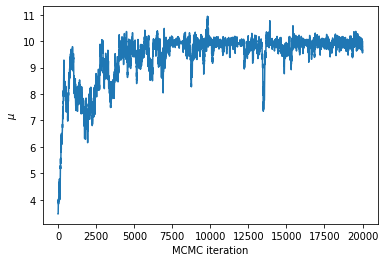

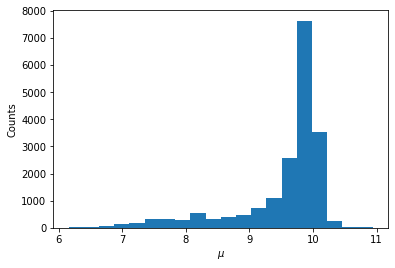

In [13]:
plt.plot(mu_chain);
plt.xlabel("MCMC iteration");
plt.ylabel("$\mu$")
plt.figure();
plt.hist(mu_chain[N_burnin:].numpy(), bins=20);
plt.xlabel("$\mu$")
plt.ylabel("Counts");

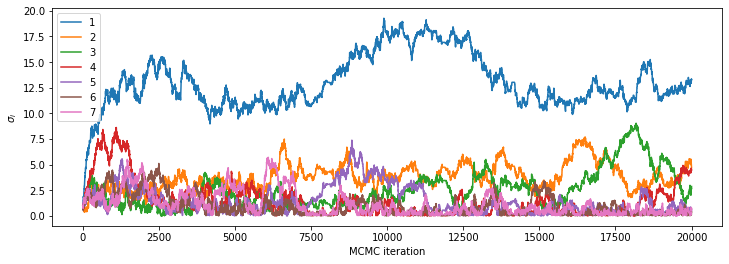

In [14]:
plt.figure(figsize=(12,4));
plt.plot(sigma_chain)
plt.legend(range(1,8));
plt.xlabel("MCMC iteration")
plt.ylabel("$\sigma_i$");

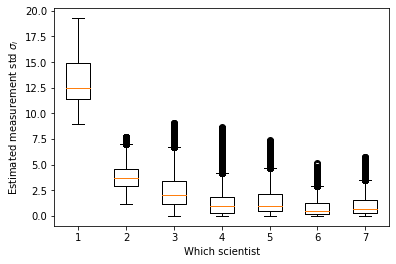

In [15]:
plt.boxplot(sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

# TASK #3 (2 points): Estimate posterior expectations

We're specifically interested in using the samples to answer the following:

1. What is the expected value of $\mu$, i.e., $\mathbb{E}[\mu ]$, under the posterior distribution?
2. What is the posterior probability that $\mu$ is less than 9, i.e. $\Pr(\mu < 9.0)$?

Both of these questions can be answered by using samples from your MCMC chain.

In [16]:
def estimate_E_mu(mu_chain, sigma_chain, N_burnin):
    """ Estimate E[mu] 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    mu : expected value of mu (scalar)
    """
    
    # YOUR CODE HERE
    return torch.mean(mu_chain[N_burnin:])
    
def estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin):
    """ Estimate the posterior probability that mu is less than 9, i.e. Pr(mu < 9) 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    estimate : estimate of Pr(mu < 9), a scalar
    """
    
    # YOUR CODE HERE
    return len([elem for elem in mu_chain[N_burnin:] if elem < 9] )/len(mu_chain[N_burnin:])

In [17]:
print("E[mu] = %0.4f" % estimate_E_mu(mu_chain, sigma_chain, N_burnin))
print("Pr(mu < 9) = %0.4f" % estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin))

E[mu] = 9.5452
Pr(mu < 9) = 0.1589


#### Ignore the following cells. They are used by the grading system.

In [18]:
# (GRADING)

In [19]:
# (GRADING)

In [20]:
# (GRADING)

In [21]:
# (GRADING)

In [22]:
# (GRADING)

# EXTRA CREDIT TASK #4 (4 points): Estimate $\alpha$ and $\beta$

Did we choose the hyperparameters $\alpha$ and $\beta$ well? Or were these poor selections?

One way of checking whether $\alpha$ and $\beta$ are set well is by computing a marginal likelihood estimate, i.e. estimating $p(x | \alpha, \beta)$ for different choices of $\alpha, \beta$.

However, a different option is to *also* perform Bayesian inference over $\alpha$ and $\beta$! To do this, we need to do three things:

1. Define a prior $p(\alpha, \beta)$
2. Define MCMC proposals $q(\alpha' | \alpha)$ and $q(\beta' | \beta)$
3. Update the MCMC algorithm itself to also sample $\alpha, \beta$.

To do this, this involves targeting the joint probability distribution

$$p(x,\mu,\sigma,\alpha,\beta) = p(x | \mu, \sigma)p(\mu | \alpha)p(\sigma | \beta)p(\alpha)p(\beta).$$

You can write your MCMC algorithm so that it alternates between doing updates on $\mu, \sigma$ (using your existing `mcmc_step` function) and doing updates on $\alpha, \beta$ (using a new `mcmc_step_hyperparams` function).

To do this you need to implement two things:

1. `log_prior_alpha_beta`: given $\alpha,\beta$, return $\log p(\alpha, \beta)$. You are free to define whatever sort of prior you think is appropriate.
2. `mcmc_step_hyperparams`: do a single MCMC step (including accept / reject) to update $\alpha, \beta$.

These will then be called by the `run_mcmc_bonus` function, below.

In [23]:
def log_prior_alpha_beta(alpha, beta):
    """
    Define a prior distribution on alpha, beta, and return its log probability
    
    INPUT:
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    log_prob : scalar, `log p(alpha, beta)`
    
    """
    
    # YOUR CODE HERE
    # the conjugate prior of the Normal with known mean and the exponential is the gamma distribution
    if beta <= 0 or alpha <= 0:
        return torch.tensor(-float("inf"))
    
    # gammma distribution with mean 50
    q_alpha = dist.Gamma(5, 0.1)
    
    # gamma distribution with mean 0.5
    q_beta = dist.Gamma(2.5, 5)
    
    
    log_probability = q_alpha.log_prob(alpha) + q_beta.log_prob(beta)
    
    return log_probability

In [24]:
def mcmc_step_hyperparams(mu, sigma, alpha, beta):
    """
    Run an MCMC step on alpha and beta
    
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    alpha    : the next value of alpha in the MCMC chain
    beta     : the next value of beta in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted
    
    """
    
    # YOUR CODE HERE
    
    accepted = False
    
    # proposal distributions with mean alpha and beta 
    q_alpha = dist.Normal(alpha, 0.1)
    q_beta = dist.Normal(beta, 0.001)
    
    # we sample new alphas and betas from proposal
    new_alpha = q_alpha.sample()
    new_beta = q_beta.sample()
    
    # we create new proposals
    q_alpha_new = dist.Normal(new_alpha, 0.1)
    q_beta_new = dist.Normal(new_beta, 0.001)
    
    # we evaluate the likelihoods of alpha and beta for both the new pair and the old one
    log_prob_ab = log_prior_alpha_beta(alpha, beta)
    log_prob_ab_new = log_prior_alpha_beta(new_alpha, new_beta)
    
    # we evaluate the joint likelihood for all the parameters
    logjoint = log_joint(mu, sigma, alpha, beta) + log_prob_ab
    logjoint_new = log_joint(mu, sigma, new_alpha, new_beta) + log_prob_ab_new
    
    # we evaluate the weighted sum of the likelihoods and proposals
    logsum = (logjoint_new
              +q_alpha_new.log_prob(alpha)
              +q_beta_new.log_prob(beta)
              -logjoint
              -q_alpha.log_prob(new_alpha)
              -q_alpha.log_prob(new_beta)
    )
    
    # if the new logjoint is better we keep the alphas and betas
    A = min(1, torch.exp_(logsum))
    
    if A > np.random.rand() :
        accepted = True
        alpha = new_alpha
        beta = new_beta
        
    return alpha, beta, accepted

### Run this MCMC algorithm, and plot the results.

What do you think?

1. Are these results qualitatively different?
2. Were the original choices of $\alpha, \beta$ reasonable?
3. How sensitive are these results to $\alpha, \beta$? To $p(\alpha, \beta)$?

In [25]:
def run_mcmc_bonus(N_iters, mu_init, sigma_init, alpha_init, beta_init):
    """ Run an MCMC algorithm for a fixed number of iterations.
    
    This also runs MCMC on "hyperparameters" alpha and beta.
    
    """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    alpha_chain = [alpha_init]
    beta_chain = [beta_init]
    for _ in range(N_iters):
        alpha, beta, accepted = mcmc_step_hyperparams(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        alpha_chain.append(alpha)
        beta_chain.append(beta)

        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), torch.stack(alpha_chain), torch.stack(beta_chain)

In [26]:
new_mu_chain, new_sigma_chain, alpha_chain, beta_chain = run_mcmc_bonus(N_samples, mu_chain[-1], sigma_chain[-1], torch.tensor(50.0), torch.tensor(0.5))

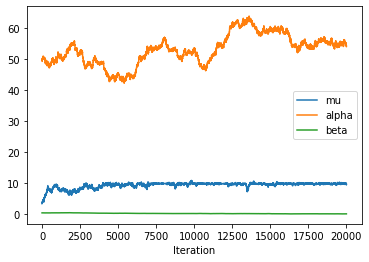

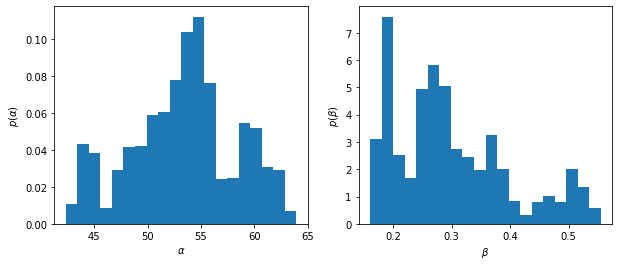

In [27]:
plt.plot(mu_chain)
plt.plot(alpha_chain);
plt.plot(beta_chain);
plt.legend(['mu', 'alpha', 'beta']);
plt.xlabel("Iteration");
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(alpha_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\alpha$")
plt.ylabel("$p(\\alpha)$")
plt.subplot(122)
plt.hist(beta_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\beta$")
plt.ylabel("$p(\\beta)$");

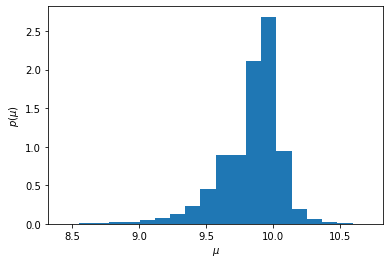

In [28]:
plt.hist(new_mu_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu)$");

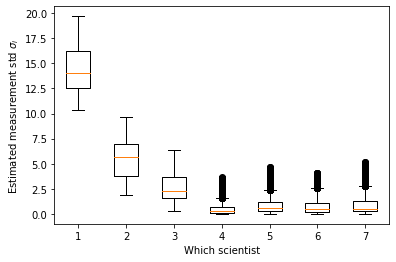

In [29]:
plt.boxplot(new_sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

In [30]:
# (GRADING)

In [31]:
# (GRADING)